## Packages

In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## ANN - Multilayer Perceptron

### Pre-processing
Wir verwenden für diesen Teil wieder die Grundwasserqualitätsdaten, die wir bereits in Termin 4 für die Binär-Klassifikation verwendet haben. Ziel ist es, mit Hilfe der anderen Parameter jeweils die Landnutzung (d.h. landwirtschaftlich ja/nein) in Form einer Binär-Klassifikation sowie die Nitrat-Gehalte in Form einer Regression vorherzusagen.

Die Daten sind bereits teilweise pre-processed (kategorische Variablen sind encodiert, Werte unter der NWG wurden ersetzt). Wir prüfen nun noch, ob Nan-Werte vorhanden sind und löschen anschließend noch nicht benötigte Spalten.

In [3]:
# Einladen der Daten
filename = 'gwdata_2005.csv'
dataset = pd.read_csv(filename, delimiter=';', encoding='latin1')

# Prüfen auf Nan-Werte
dataset.isnull().sum()


GWNum           0
Messstelle      0
Ca              0
Cl              0
DOC             0
LF_mS_m         0
K               0
Mg              0
Na              0
NO3             0
pH             50
SO4             0
SiO2            0
U               0
PSM             0
Rechtswert      0
Hochwert        0
Aquifer_kz      0
Aquifer         6
Aquifer2        0
landuse         0
landuse_num     0
dtype: int64

In [4]:
# Pre-processing

dataset_cleaned = dataset.dropna()

mydata = dataset_cleaned.drop(['GWNum','Messstelle','Rechtswert', 'Hochwert', 'Aquifer','Aquifer2','landuse'], axis=1)
mydata.head()

,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,NO3,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,12.4,6.92,15.6,8.9,0.00025,0.0,31,0
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,4.5,6.78,2.0,10.7,0.00025,0.0,81,0
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,4.0,6.69,4.0,16.0,0.00025,0.0,91,0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.4,6.96,3.4,18.6,0.00025,0.0,91,0
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,18.2,7.25,23.1,12.3,0.00025,0.0,4,0


## Klassifikation
### Splitten der Daten

Das Aufteilen des Datensatzes erfolgt mit der Funktion "train_test_split" des Packages sklearn.

Hier kann mit dem Parameter "test_size" das Verhältnis festgelegt werden und mit dem Parameter "random_state" die Reproduzierbarkeit garantiert werden. Der Testdatensatz dient später dazu, zu evaluieren, wie gut das trainierte neuronale Netz generalisieren kann, d.h. Daten vorhersagen, die es vorher "noch nie gesehen hat".

Um Overfitting zu vermeiden und/oder das ANN hinsichtlich sog. Hyperparameter zu optimieren müssen wir die vorhandenen Daten weiter in einzelne Datensätze aufteilen. Je nach Zusammenhang bzw. Verwendung werden diese als Stopp-Set, Optimierungs-Set oder als Validation-Set bezeichnet. Diese können ebenfalls mit der Funktion train_test_split erzeugt werden.

Für den Anfang wollen wir lediglich einen weiteren Datensatz, um Overfitting zu vermeiden. Dieser wird später bei jedem Trainingsschritt parallel beobachtet. Das ursprüngliche Training-Set (zunächst als temp bezeichnet) teilen wir dazu erneut auf:

In [5]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

temp, test = train_test_split(mydata, test_size=0.2, random_state=27)

train, val = train_test_split(temp, test_size=0.1, random_state=27)

print('Größe Trainings-Set: ', train.shape)
print('Größe Validation-Set: ', val.shape)
print('Größe Test-Set: ', test.shape)

Größe Trainings-Set:  (1352, 15)
Größe Validation-Set:  (151, 15)
Größe Test-Set:  (376, 15)


### Skalieren

Für neuronale Netze müssen die Eingangsdaten skaliert werden. Je nach Datensatz und Fragestellung kann man die Daten entweder Normieren oder Standardisieren (siehe Übung Termin 2). Wir wählen hier die Normierung, damit unsere landuse_num Kategorien erhalten bleiben.

Der Scaler wird zunächst an die Daten des Trainings-Set gefittet. Anschließend werden sowohl Trainings-Set,  Validation-Set und Test-Set transformiert.

In [6]:
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### Aufteilen der Daten in Input- und Zieldaten

In [7]:
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_val = val[:, :-1] # for all but last column --> Input variables
y_val = val[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable

### Aufbau und Training des ANN

Wir importieren zunächst weitere nötige Pakete, und lesen dann die Anzahl der Input-features aus. Anschließend erstellen wir ein einfaches ANN mit einer Eingabeschicht (welche automatisch auf Basis der Anzahl der Input-Features erzeugt wird), einer verdeckten Schicht mit 5 Neuronen und einer Ausgabeschicht mit einem Neuron für unseren Zielwert (Nitrat). Vollständig miteinerander verbundene Schichten (fully connected layers) werden in Keras als Dense-Layer bezeichnet.

Weitere Hyperparameter des Modells (neben der Anzahl der Schichten und Neuronen) sind die Initialisierungsfunktion, die Aktivierungsfunktion, der Optimizer und die Batch-Size (Anzahl der Inputs, die dem Netz pro Epoche auf einmal präsentiert werden). Diese werden zunächst relativ wahllos gewählt. Als Aktivierungsfunktion verwenden wir "ReLu" für die verdeckte Schicht, was für die meisten Problem in der Regel gut funktioniert. Für die Ausgabeschicht verwenden wir eine sigmoidale Aktivierungsfunktion, um sicherzustellen, dass die Ausgabe des Netzwerks zwischen 0 und 1 liegt und sich leicht auf eine der beiden Klassen mit einem Standard-Schwellenwert von 0,5 abbilden lässt. Der Adam-Optimizer gilt ebenfalls für viele Probleme als Methode der Wahl. Bei der Batch-Size findet man häufig Anfangswerte von 16, 32 oder 64. Alle Hyperparameter können später "optimiert" werden. Als loss-Funktion kommt für die binäre Klassifikation "binary_crossentropy" zum Einsatz, als Metrik die "accuracy". Zunächst starten wir mit 50 Epochen.

Nach dem eigentlichen Training (model.fit) führen wir mit model.evaluate eine Vorhersage mit den validation-Inputs aus, um einen Hinweis dafür zu bekommen, wie gut das Modell ist.

Epoch 1/50
85/85 [==============================] - 0s 2ms/step - loss: 5.9609 - accuracy: 0.6124 - val_loss: 5.0061 - val_accuracy: 0.6755
Epoch 2/50
85/85 [==============================] - 0s 786us/step - loss: 5.3549 - accuracy: 0.6124 - val_loss: 2.8711 - val_accuracy: 0.6755
Epoch 3/50
85/85 [==============================] - 0s 798us/step - loss: 1.8692 - accuracy: 0.6124 - val_loss: 0.9912 - val_accuracy: 0.6689
Epoch 4/50
85/85 [==============================] - 0s 798us/step - loss: 0.8347 - accuracy: 0.6109 - val_loss: 0.8445 - val_accuracy: 0.6755
Epoch 5/50
85/85 [==============================] - 0s 786us/step - loss: 0.7632 - accuracy: 0.6072 - val_loss: 0.8274 - val_accuracy: 0.6755
Epoch 6/50
85/85 [==============================] - 0s 750us/step - loss: 0.6946 - accuracy: 0.6043 - val_loss: 0.6629 - val_accuracy: 0.6623
Epoch 7/50
85/85 [==============================] - 0s 762us/step - loss: 0.6790 - accuracy: 0.6028 - val_loss: 0.6621 - val_accuracy: 0.6689
Epoch 8/

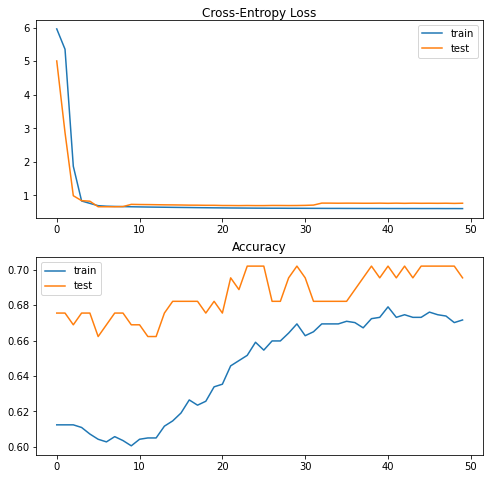

In [9]:
# import packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from matplotlib import pyplot

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# define model
model = Sequential()
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer, input_shape=(n_features,)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_val,y_val))

# make class predictions with the model
predictions = (model.predict(X_val) > 0.5).astype("int32")

# compute accuracy
_, accuracy = model.evaluate(X_val,y_val)
print('Accuracy: %.2f' % (accuracy*100))

# plot loss learning curves

pyplot.figure(figsize=(8,8)) 
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Falls wir sehen, dass ein Overfitting eintritt, können wir die Anzahl der Epochen von Hand anpassen und einen zweiten Durchlauf starten (später mehr zu Techniken, wie man das Training im Fall von Overfitting automatisch stoppen kann).

Die Accuracy beträgt bei diesem sehr einfachen und nicht optimierten Modell für die Validierungsdaten immerhin etwa 66% und ist damit in etwa vergleichbar mit der Performance des SVM/Scaled SVM aus Termin 4 (aber nicht so gut wie Random Forest). Da diese Konfiguration ganz gut zu funktionieren scheint, bauen wir das Modell nochmals neu auf, trainieren es mit dem kompletten Trainingsdatensatz (inklusive der Validierungs-Daten) und sagen damit die Landnutzung unseres Test-Datensatzes voraus.

In [10]:
seed(1)
tf.random.set_seed(2)

# Split data
train, test = train_test_split(mydata, test_size=0.2, random_state=27)

# Scale data
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

# Input- and Target-Data
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable


# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()


# define model
model = Sequential()
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer, input_shape=(n_features,)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# make class predictions with the model
#predictions = model.predict_classes(X_val)

# compute accuracy
_, accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/50
94/94 [==============================] - 0s 602us/step - loss: 1.6967 - accuracy: 0.4864
Epoch 2/50
94/94 [==============================] - 0s 613us/step - loss: 0.7390 - accuracy: 0.5416
Epoch 3/50
94/94 [==============================] - 0s 624us/step - loss: 0.7107 - accuracy: 0.5642
Epoch 4/50
94/94 [==============================] - 0s 635us/step - loss: 0.6984 - accuracy: 0.5742
Epoch 5/50
94/94 [==============================] - 0s 624us/step - loss: 0.6864 - accuracy: 0.5782
Epoch 6/50
94/94 [==============================] - 0s 624us/step - loss: 0.6728 - accuracy: 0.5908
Epoch 7/50
94/94 [==============================] - 0s 613us/step - loss: 0.6597 - accuracy: 0.6121
Epoch 8/50
94/94 [==============================] - 0s 613us/step - loss: 0.6486 - accuracy: 0.6254
Epoch 9/50
94/94 [==============================] - 0s 624us/step - loss: 0.6402 - accuracy: 0.6460
Epoch 10/50
94/94 [==============================] - 0s 613us/step - loss: 0.6349 - accuracy: 0.6507

Auch dies scheint offensichtlich ähnlich gut zu funktionieren, die Vorhersage-Genauigkeit für den Test-Datensatz beträgt in diesem Durchlauf etwa 66 %. Die eigentlichen Daten können je nach Durchlauf aufgrund der unterschiedlichen Initialisierungen variieren. Wie man das Modell robuster macht, dazu bei der Regression mehr.

## Regression

### Splitten der Daten

Zunächst sortieren für die Regression nun die Spalten so um, dass die Spalte mit den Werten, die wir später vorhersagen wollen, in diesem Fall Nitrat, am Ende steht. Das macht uns  die Aufteilung in Input- und Zieldaten leichter. Anschließend wiederholen wir die  Skalierung und Aufteilung der Daten.

Das Aufteilen des Datensatzes erfolgt mit der Funktion "train_test_split" des Packages sklearn.

Hier kann mit dem Parameter "test_size" das Verhältnis festgelegt werden und mit dem Parameter "random_state" die Reproduzierbarkeit garantiert werden. Der Testdatensatz dient später dazu, zu evaluieren, wie gut das trainierte neuronale Netz generalisieren kann, d.h. Daten vorhersagen, die es vorher "noch nie gesehen hat".

Um Overfitting zu vermeiden und/oder das ANN hinsichtlich sog. Hyperparameter zu optimieren müssen wir die vorhandenen Daten weiter in einzelne Datensätze aufteilen. Je nach Zusammenhang bzw. Verwendung werden diese als Stopp-Set, Optimierungs-Set oder als Validation-Set bezeichnet. Diese können ebenfalls mit der Funktion train_test_split erzeugt werden.

Für den Anfang wollen wir lediglich einen weiteren Datensatz, um Overfitting zu vermeiden. Dieser wird später bei jedem Trainingsschritt parallel beobachtet. Das ursprüngliche Training-Set (zunächst als temp bezeichnet) teilen wir dazu erneut auf.



In [11]:
mydata_reg = mydata[['Ca','Cl','DOC','LF_mS_m','K','Mg','Na','pH','SO4','SiO2','U','PSM','Aquifer_kz','landuse_num','NO3']]
mydata_reg.head()

,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num,NO3
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,6.92,15.6,8.9,0.00025,0.0,31,0,12.4
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,6.78,2.0,10.7,0.00025,0.0,81,0,4.5
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,6.69,4.0,16.0,0.00025,0.0,91,0,4.0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.96,3.4,18.6,0.00025,0.0,91,0,6.4
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,7.25,23.1,12.3,0.00025,0.0,4,0,18.2


In [12]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

temp, test = train_test_split(mydata, test_size=0.2, random_state=27)

train, val = train_test_split(temp, test_size=0.1, random_state=27)

print('Größe Trainings-Set: ', train.shape)
print('Größe Validation-Set: ', val.shape)
print('Größe Test-Set: ', test.shape)

Größe Trainings-Set:  (1352, 15)
Größe Validation-Set:  (151, 15)
Größe Test-Set:  (376, 15)


### Skalieren

Für neuronale Netze müssen die Eingangsdaten skaliert werden. Je nach Datensatz und Fragestellung kann man die Daten entweder Normieren oder Standardisieren (siehe Übung Termin 2). Wir wählen hier die Standardisierung, die für Regressionsproblem gut geeignet ist.

Der Scaler wird zunächst an die Daten des Trainings-Set gefittet. Anschließend werden sowohl Trainings-Set,  Validation-Set und Test-Set transformiert.

In [13]:
scaler = StandardScaler()
scaler.fit(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### Aufteilen der Daten in Input- und Zieldaten

In [14]:
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_val = val[:, :-1] # for all but last column --> Input variables
y_val = val[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable

### Aufbau und Training des ANN

Wir importieren zunächst weitere nötige Pakete, und lesen dann die Anzahl der Input-features aus. Anschließend erstellen wir ein einfaches ANN mit einer Eingabeschicht (welche automatisch auf Basis der Anzahl der Input-Features erzeugt wird), einer verdeckten Schicht mit 5 Neuronen und einer Ausgabeschicht mit einem Neuron für unseren Zielwert (Nitrat).

Weitere Hyperparameter des Modells (neben der Anzahl der Schichten und Neuronen) sind die Initialisierungsfunktion, die Aktivierungsfunktion, der Optimizer und die Batch-Size (Anzahl der Inputs, die dem Netz pro Epoche auf einmal präsentiert werden). Diese werden zunächst relativ wahllos gewählt. Als Aktivierungsfunktion verwenden wir für die verdeckte Schicht "ReLu", was für Regressionsprobleme in der Regel gut funktioniert. Für die Ausgabeschicht wird keine Aktivierungsfunktion verwendet, da es sich um ein Regressionsproblem handelt und wir daran interessiert sind, numerische Werte direkt ohne Transformation vorherzusagen.

Der Adam-Optimizer gilt ebenfalls für viele Probleme als Methode der Wahl. Bei der Batch-Size findet man häufig Anfangswerte von 16, 32 oder 64. Alle Hyperparameter können später "optimiert" werden.

Als loss-Funktion kommt für die Regression der mean squared error zum Einsatz. Die Anzahl der Epochen erhöhen wir zunächst auf 100, da eine Regression ein komplexeres Problem darstellt, das evtl. mehr Training benötigt.

Nach dem eigentlichen Training (model.fit) führen wir eine Vorhersage mit den validation-Inputs aus, um einen Hinweis dafür zu bekommen, wie gut das Modell ist. Dazu vergleichen wir die Vorhersage mit den bekannten Zielwerten und berechnen den MSE.

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

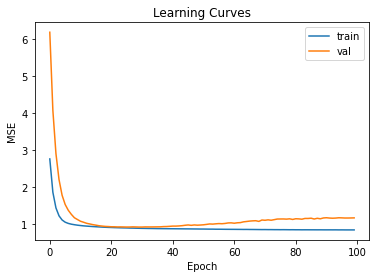

In [15]:
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from matplotlib import pyplot

seed(1)
tf.random.set_seed(2)

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# define model
model = Sequential()
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer, input_shape=(n_features,)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=3, validation_data=(X_val,y_val))

# predict test set
yhat = model.predict(X_val)

# evaluate predictions
score = mean_squared_error(y_val, yhat)
print('MSE: %.3f' % score)

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Wir sehen, dass ab etwa 30 Epochen ein Overfitting eintritt. Da dies aber sehr stark von den tatsächlichen Eingangsdaten sowie der Initialisierung abhängt, ist es besser, keine absolute Zahl festzulegen, sondern die Technik des "Early Stopping" anzuwenden. Dabei werden nach jeder Epoche die Gewichte abgespeichert und sobald sich der Fehler im Validierungsdatensatz für eine bestimmte Anzahl von Epochen nicht mehr verbessert, bricht das Training ab (Early Stopping) und springt zu den gespeicherten Gewichten des "besten" Durchlaufs zurück.

Im Folgenden der Code von oben mit Early Stopping. Dabei empfiehlt es sich, die Anzahl der Epochen etwas höher zu setzen, damit das Early Stopping auch greifen kann.

Epoch 1/100
85/85 [==============================] - 0s 1ms/step - loss: 2.7686 - val_loss: 6.1910
Epoch 2/100
85/85 [==============================] - 0s 738us/step - loss: 1.8683 - val_loss: 4.0805
Epoch 3/100
85/85 [==============================] - 0s 738us/step - loss: 1.4461 - val_loss: 2.9142
Epoch 4/100
85/85 [==============================] - 0s 738us/step - loss: 1.2323 - val_loss: 2.2119
Epoch 5/100
85/85 [==============================] - 0s 749us/step - loss: 1.1203 - val_loss: 1.7881
Epoch 6/100
85/85 [==============================] - 0s 738us/step - loss: 1.0606 - val_loss: 1.5389
Epoch 7/100
85/85 [==============================] - 0s 738us/step - loss: 1.0278 - val_loss: 1.3834
Epoch 8/100
85/85 [==============================] - 0s 726us/step - loss: 1.0067 - val_loss: 1.2728
Epoch 9/100
85/85 [==============================] - 0s 750us/step - loss: 0.9922 - val_loss: 1.1805
Epoch 10/100
85/85 [==============================] - 0s 738us/step - loss: 0.9797 - val_loss

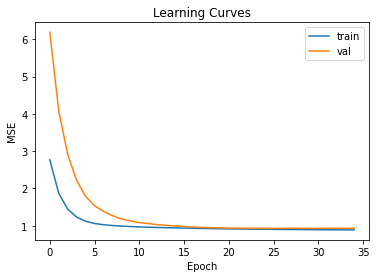

In [16]:
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot

seed(1)
tf.random.set_seed(2)

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# define model
model = Sequential()
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer, input_shape=(n_features,)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val),
                    callbacks=[es])

# predict test set
yhat = model.predict(X_val)

# evaluate predictions
score = mean_squared_error(y_val, yhat)
print('MSE: %.3f' % score)

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### kfold Crossvalidation
Um nun zu testen, wie robust die Vorhersage ist, wiederholen wir das Ganze mit einer kfold crossvalidation, d.h. wir splitten unsere Daten in jeweils 90% Trainings- und 10% Validierungsdaten. Dafür müssen wir die Reihenfolge des Datensplitting und der Skalierung ggü. oben etwas umstellen. Das Training und die Validation werden anschließend in einer Schleife ausgeführt.

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Restoring model weights from the end of the best epoch: 60.
Epoch 00065: early stopping
MSE: 0.738


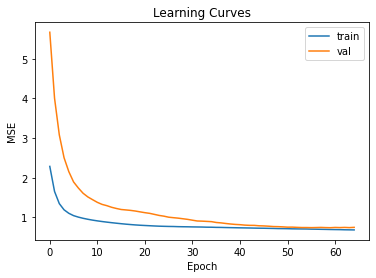

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

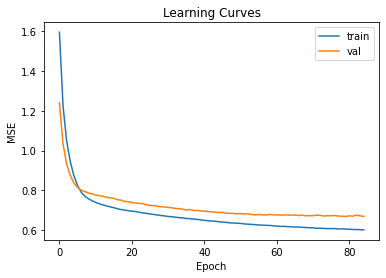

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Restoring model weights from the end of the best epoch: 31.
Epoch 00036: early stopping
MSE: 0.680


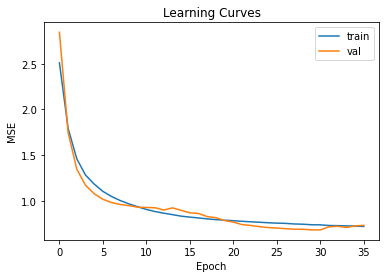

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Restoring model weights from the end of the best epoch: 22.
Epoch 00027: early stopping
MSE: 0.810


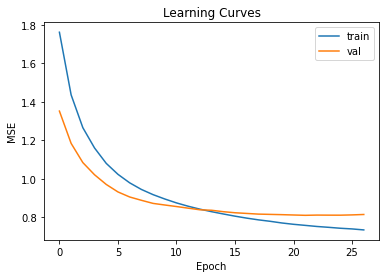

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

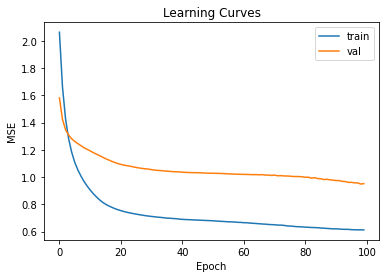

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Restoring model weights from the end of the best epoch: 31.
Epoch 00036: early stopping
MSE: 0.735


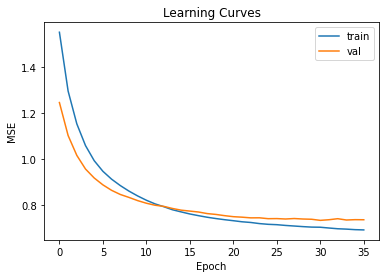

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Restoring model weights from the end of the best epoch: 16.
Epoch 00021: early stopping
MSE: 0.723


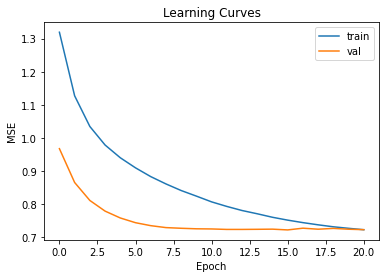

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

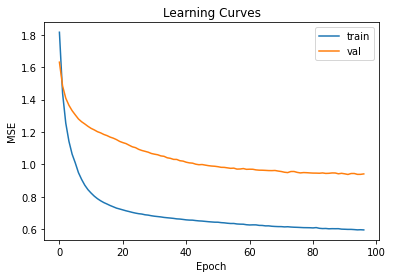

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Restoring model weights from the end of the best epoch: 45.
Epoch 00050: early stopping
MSE: 0.655


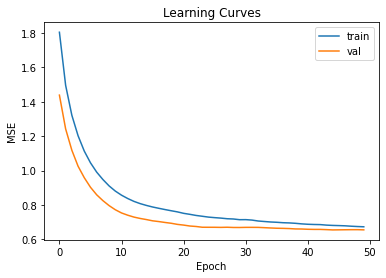

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Restoring model weights from the end of the best epoch: 39.
Epoch 00044: early stopping
MSE: 0.376


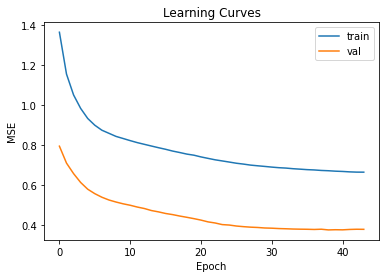

Mean MSE: 0.728 (0.154)


In [17]:
seed(1)
tf.random.set_seed(2)

temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
scaler.fit(temp)

temp = scaler.transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]

X_test, y_test = test[:, :-1], test[:, -1]


# prepare cross validation
from numpy import mean
from numpy import std

kfold = KFold(10, shuffle=True, random_state=27)

# enumerate splits
scores = list()


for train_ix, val_ix in kfold.split(X, y):
    # split data
    X_train, X_val, y_train, y_val = X[train_ix], X[val_ix], y[train_ix], y[val_ix]
    # determine the number of input features
    n_features = X.shape[1]
    # set initializer
    kernel_initializer = initializers.glorot_uniform
    
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    # define model
    model = Sequential()
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer, input_shape=(n_features,)))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val),
                       callbacks=[es])

    # predict test set
    yhat = model.predict(X_val)
    score = mean_squared_error(y_val, yhat)
    print('MSE: %.3f' % score)
    scores.append(score)
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('MSE')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()


# summarize all scores
print('Mean MSE: %.3f (%.3f)' % (mean(scores), std(scores)))

Wir sehen, dass sich sowohl der Verlauf der Lernkurven als auch die Performance (also der MSE) der einzelnen Durchläufe zum Teil stark unterscheiden kann, was zum Einen von den unterschiedlichen Initialisierungen und zum Anderem von der Aufteilung des Datensatzes abhängt.

Auch bei einer zufälligen Aufteilung kann es sein, dass "zufällig" mehr schwierig vorherzusagende Werte im Validierungsatz landen. Dies sind vor allem Werte, die in der Verteilung der Trainingsdaten seltener vorkommen. Im Beispiel von Nitrat wären das hohe Messwerte. Daher ist es wichtig, mit einer kfold-Crossvalidation die mittlere Performance zu betrachten.

Dem Problem der Initialisierung begegnet man in der Regel damit, dass man viele Modelle mit unterschiedlichen Initialisierungen rechnet (also ein Ensemble bildet) und dann jeweils die mittlere Vorhersage aller Modelle betrachtet.

### Optimierung von Hyperparametern (der "einfache" Weg)

Ein einfacher Weg, Hyperparameter wie die Batchsize, Lernregel usw. zu optimieren, ist es, einfach alle möglichen Kombinationen durchzuprobieren. Dies wird als "grid search" bezeichnet. Der Vorteil ist, dass man auf jeden Fall die beste Variante finden wird, der Nachteil ist, dass bei einer größeren Anzahl von zu optimierenden Hyperparametern und deren jeweils mögliche Werte(-bereiche) die Anzahl der möglichen Kombinationen schnell so groß wird, dass eine grid search zeitlich gar nicht mehr möglich ist. Es gibt aber noch weitere, effizientere Methoden, dazu in einer späteren Vorlesung mehr.

Im Folgenden führen wir eine kleine grid search durch, wobei wir zwei weitere Optimizer, drei verschiedene Epochen-Anzahlen und drei verschiedene Batch-Sizes testen (also 27 mögliche Kombinationen). Schon das könnte je nach Rechner ganz schön lange dauern. Falls es zu lange dauert, können wir die Anzahl der zu optimierenden Parameter reduzieren.


In [19]:
import scikeras
from scikeras.wrappers import KerasRegressor

ModuleNotFoundError: No module named 'scikeras'

In [18]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

seed(1)
tf.random.set_seed(2)

def baseline_model(optimizer='adam'):
   
    # define model
    model = Sequential()
    model.add(Dense(5, activation='relu', kernel_initializer='glorot_uniform', input_shape=(n_features,)))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data
temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
scaler.fit(temp)

temp = scaler.transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]

    
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=16, verbose=1)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam', 'SGD']
epochs = [30, 50, 70]
batches = [8, 16, 32]

param_grid = dict(optimizer=optimizers,
epochs=epochs,
batch_size=batches)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Tanja\AppData\Local\Temp\ipykernel_33508\3309337711.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=16, verbose=1)


Epoch 1/30
151/151 [==============================] - 0s 527us/step - loss: 2.6410
Epoch 2/30
151/151 [==============================] - 0s 493us/step - loss: 1.7568
Epoch 3/30
151/151 [==============================] - 0s 507us/step - loss: 1.2703
Epoch 4/30
151/151 [==============================] - 0s 493us/step - loss: 1.1008
Epoch 5/30
151/151 [==============================] - 0s 487us/step - loss: 1.0205
Epoch 6/30
151/151 [==============================] - 0s 500us/step - loss: 0.9588
Epoch 7/30
151/151 [==============================] - 0s 507us/step - loss: 0.9142
Epoch 8/30
151/151 [==============================] - 0s 480us/step - loss: 0.8823
Epoch 9/30
151/151 [==============================] - 0s 480us/step - loss: 0.8537
Epoch 10/30
151/151 [==============================] - 0s 473us/step - loss: 0.8331
Epoch 11/30
151/151 [==============================] - 0s 487us/step - loss: 0.8166
Epoch 12/30
151/151 [==============================] - 0s 487us/step - loss: 0.8031
E

Epoch 7/30
151/151 [==============================] - 0s 493us/step - loss: 0.8824
Epoch 8/30
151/151 [==============================] - 0s 507us/step - loss: 0.8517
Epoch 9/30
151/151 [==============================] - 0s 500us/step - loss: 0.8333
Epoch 10/30
151/151 [==============================] - 0s 493us/step - loss: 0.8144
Epoch 11/30
151/151 [==============================] - 0s 507us/step - loss: 0.7987
Epoch 12/30
151/151 [==============================] - 0s 507us/step - loss: 0.7852
Epoch 13/30
151/151 [==============================] - 0s 500us/step - loss: 0.7738
Epoch 14/30
151/151 [==============================] - 0s 493us/step - loss: 0.7649
Epoch 15/30
151/151 [==============================] - 0s 507us/step - loss: 0.7572
Epoch 16/30
151/151 [==============================] - 0s 500us/step - loss: 0.7487
Epoch 17/30
151/151 [==============================] - 0s 500us/step - loss: 0.7424
Epoch 18/30
151/151 [==============================] - 0s 500us/step - loss: 0.

Epoch 13/30
151/151 [==============================] - 0s 493us/step - loss: 0.7369
Epoch 14/30
151/151 [==============================] - 0s 500us/step - loss: 0.7287
Epoch 15/30
151/151 [==============================] - 0s 487us/step - loss: 0.7189
Epoch 16/30
151/151 [==============================] - 0s 513us/step - loss: 0.7111
Epoch 17/30
151/151 [==============================] - 0s 507us/step - loss: 0.7041
Epoch 18/30
151/151 [==============================] - 0s 513us/step - loss: 0.6982
Epoch 19/30
151/151 [==============================] - 0s 507us/step - loss: 0.6931
Epoch 20/30
151/151 [==============================] - 0s 520us/step - loss: 0.6893
Epoch 21/30
151/151 [==============================] - 0s 513us/step - loss: 0.6841
Epoch 22/30
151/151 [==============================] - 0s 500us/step - loss: 0.6825
Epoch 23/30
151/151 [==============================] - 0s 513us/step - loss: 0.6798
Epoch 24/30
151/151 [==============================] - 0s 513us/step - loss:

151/151 [==============================] - 0s 467us/step - loss: 0.7452
Epoch 25/30
151/151 [==============================] - 0s 467us/step - loss: 0.7367
Epoch 26/30
151/151 [==============================] - 0s 460us/step - loss: 0.7313
Epoch 27/30
151/151 [==============================] - 0s 453us/step - loss: 0.7304
Epoch 28/30
151/151 [==============================] - 0s 453us/step - loss: 0.7260
Epoch 29/30
151/151 [==============================] - 0s 453us/step - loss: 0.7227
Epoch 30/30
38/38 [==============================] - 0s 405us/step
Epoch 1/30
151/151 [==============================] - 0s 493us/step - loss: 1.0617
Epoch 2/30
151/151 [==============================] - 0s 480us/step - loss: 0.8879
Epoch 3/30
151/151 [==============================] - 0s 467us/step - loss: 0.8625
Epoch 4/30
151/151 [==============================] - 0s 467us/step - loss: 0.8437
Epoch 5/30
151/151 [==============================] - 0s 473us/step - loss: 0.8258
Epoch 6/30
151/151 [======

151/151 [==============================] - 0s 507us/step - loss: 0.7180
Epoch 31/50
151/151 [==============================] - 0s 513us/step - loss: 0.7158
Epoch 32/50
151/151 [==============================] - 0s 520us/step - loss: 0.7070
Epoch 33/50
151/151 [==============================] - 0s 520us/step - loss: 0.7095
Epoch 34/50
151/151 [==============================] - 0s 520us/step - loss: 0.7053
Epoch 35/50
151/151 [==============================] - 0s 513us/step - loss: 0.7099
Epoch 36/50
151/151 [==============================] - 0s 513us/step - loss: 0.7069
Epoch 37/50
151/151 [==============================] - 0s 520us/step - loss: 0.7020
Epoch 38/50
151/151 [==============================] - 0s 513us/step - loss: 0.7070
Epoch 39/50
151/151 [==============================] - 0s 513us/step - loss: 0.7097
Epoch 40/50
151/151 [==============================] - 0s 520us/step - loss: 0.7050
Epoch 41/50
151/151 [==============================] - 0s 507us/step - loss: 0.6982
Epoc

151/151 [==============================] - 0s 500us/step - loss: 0.7601
Epoch 23/50
151/151 [==============================] - 0s 513us/step - loss: 0.7600
Epoch 24/50
151/151 [==============================] - 0s 500us/step - loss: 0.7569
Epoch 25/50
151/151 [==============================] - 0s 500us/step - loss: 0.7503
Epoch 26/50
151/151 [==============================] - 0s 493us/step - loss: 0.7522
Epoch 27/50
151/151 [==============================] - 0s 493us/step - loss: 0.7478
Epoch 28/50
151/151 [==============================] - 0s 500us/step - loss: 0.7526
Epoch 29/50
151/151 [==============================] - 0s 493us/step - loss: 0.7457
Epoch 30/50
151/151 [==============================] - 0s 487us/step - loss: 0.7451
Epoch 31/50
151/151 [==============================] - 0s 513us/step - loss: 0.7427
Epoch 32/50
151/151 [==============================] - 0s 500us/step - loss: 0.7365
Epoch 33/50
151/151 [==============================] - 0s 500us/step - loss: 0.7390
Epoc

151/151 [==============================] - 0s 507us/step - loss: 0.7666
Epoch 15/50
151/151 [==============================] - 0s 507us/step - loss: 0.7570
Epoch 16/50
151/151 [==============================] - 0s 507us/step - loss: 0.7531
Epoch 17/50
151/151 [==============================] - 0s 507us/step - loss: 0.7450
Epoch 18/50
151/151 [==============================] - 0s 507us/step - loss: 0.7407
Epoch 19/50
151/151 [==============================] - 0s 500us/step - loss: 0.7349
Epoch 20/50
151/151 [==============================] - 0s 507us/step - loss: 0.7319
Epoch 21/50
151/151 [==============================] - 0s 500us/step - loss: 0.7283
Epoch 22/50
151/151 [==============================] - 0s 513us/step - loss: 0.7255
Epoch 23/50
151/151 [==============================] - 0s 500us/step - loss: 0.7222
Epoch 24/50
151/151 [==============================] - 0s 500us/step - loss: 0.7180
Epoch 25/50
151/151 [==============================] - 0s 513us/step - loss: 0.7166
Epoc

151/151 [==============================] - 0s 480us/step - loss: 0.9161
Epoch 7/50
151/151 [==============================] - 0s 480us/step - loss: 0.8946
Epoch 8/50
151/151 [==============================] - 0s 473us/step - loss: 0.8780
Epoch 9/50
151/151 [==============================] - 0s 480us/step - loss: 0.8753
Epoch 10/50
151/151 [==============================] - 0s 473us/step - loss: 0.8603
Epoch 11/50
151/151 [==============================] - 0s 480us/step - loss: 0.8502
Epoch 12/50
151/151 [==============================] - 0s 480us/step - loss: 0.8408
Epoch 13/50
151/151 [==============================] - 0s 480us/step - loss: 0.8228
Epoch 14/50
151/151 [==============================] - 0s 487us/step - loss: 0.8072
Epoch 15/50
151/151 [==============================] - 0s 487us/step - loss: 0.8046
Epoch 16/50
151/151 [==============================] - 0s 473us/step - loss: 0.7927
Epoch 17/50
151/151 [==============================] - 0s 480us/step - loss: 0.7815
Epoch 1

151/151 [==============================] - 0s 500us/step - loss: 0.6107
Epoch 50/70
151/151 [==============================] - 0s 513us/step - loss: 0.6107
Epoch 51/70
151/151 [==============================] - 0s 513us/step - loss: 0.6064
Epoch 52/70
151/151 [==============================] - 0s 507us/step - loss: 0.6062
Epoch 53/70
151/151 [==============================] - 0s 500us/step - loss: 0.6095
Epoch 54/70
151/151 [==============================] - 0s 500us/step - loss: 0.6028
Epoch 55/70
151/151 [==============================] - 0s 507us/step - loss: 0.6026
Epoch 56/70
151/151 [==============================] - 0s 507us/step - loss: 0.6014
Epoch 57/70
151/151 [==============================] - 0s 507us/step - loss: 0.6047
Epoch 58/70
151/151 [==============================] - 0s 507us/step - loss: 0.6001
Epoch 59/70
151/151 [==============================] - 0s 500us/step - loss: 0.6020
Epoch 60/70
151/151 [==============================] - 0s 507us/step - loss: 0.5982
Epoc

151/151 [==============================] - 0s 507us/step - loss: 0.7156
Epoch 33/70
151/151 [==============================] - 0s 500us/step - loss: 0.7175
Epoch 34/70
151/151 [==============================] - 0s 493us/step - loss: 0.7183
Epoch 35/70
151/151 [==============================] - 0s 527us/step - loss: 0.7152
Epoch 36/70
151/151 [==============================] - 0s 533us/step - loss: 0.7100
Epoch 37/70
151/151 [==============================] - 0s 513us/step - loss: 0.7062
Epoch 38/70
151/151 [==============================] - 0s 518us/step - loss: 0.7118
Epoch 39/70
151/151 [==============================] - 0s 513us/step - loss: 0.7066
Epoch 40/70
151/151 [==============================] - 0s 520us/step - loss: 0.7086
Epoch 41/70
151/151 [==============================] - 0s 520us/step - loss: 0.7053
Epoch 42/70
151/151 [==============================] - 0s 520us/step - loss: 0.7059
Epoch 43/70
151/151 [==============================] - 0s 513us/step - loss: 0.7059
Epoc

151/151 [==============================] - 0s 507us/step - loss: 0.6423
Epoch 60/70
151/151 [==============================] - 0s 520us/step - loss: 0.6419
Epoch 61/70
151/151 [==============================] - 0s 507us/step - loss: 0.6427
Epoch 62/70
151/151 [==============================] - 0s 500us/step - loss: 0.6406
Epoch 63/70
151/151 [==============================] - 0s 513us/step - loss: 0.6399
Epoch 64/70
151/151 [==============================] - 0s 507us/step - loss: 0.6382
Epoch 65/70
151/151 [==============================] - 0s 513us/step - loss: 0.6387
Epoch 66/70
151/151 [==============================] - 0s 513us/step - loss: 0.6390
Epoch 67/70
151/151 [==============================] - 0s 513us/step - loss: 0.6350
Epoch 68/70
151/151 [==============================] - 0s 507us/step - loss: 0.6347
Epoch 69/70
151/151 [==============================] - 0s 513us/step - loss: 0.6338
Epoch 70/70
38/38 [==============================] - 0s 433us/step
Epoch 1/70
151/151 [=

151/151 [==============================] - 0s 557us/step - loss: 0.7406
Epoch 43/70
151/151 [==============================] - 0s 507us/step - loss: 0.7394
Epoch 44/70
151/151 [==============================] - 0s 560us/step - loss: 0.7382
Epoch 45/70
151/151 [==============================] - 0s 553us/step - loss: 0.7379
Epoch 46/70
151/151 [==============================] - 0s 513us/step - loss: 0.7338
Epoch 47/70
151/151 [==============================] - 0s 513us/step - loss: 0.7350
Epoch 48/70
151/151 [==============================] - 0s 507us/step - loss: 0.7326
Epoch 49/70
151/151 [==============================] - 0s 493us/step - loss: 0.7318
Epoch 50/70
151/151 [==============================] - 0s 500us/step - loss: 0.7317
Epoch 51/70
151/151 [==============================] - 0s 507us/step - loss: 0.7300
Epoch 52/70
151/151 [==============================] - 0s 540us/step - loss: 0.7279
Epoch 53/70
151/151 [==============================] - 0s 560us/step - loss: 0.7263
Epoc

KeyboardInterrupt: 

### Vorhersage der Test-Daten mit dem besten Modell

Jetzt wo wir wissen, was die beste Hyperparameter-Kombination ist, bauen wir das Modell nochmals neu auf, trainieren es mit dem kompletten Trainingsdatensatz (inklusive der Valididierungs-Daten) und sagen damit die Nitrat-Werte unseres Test-Datensatzes voraus. Ggf. weicht die "beste" Hyperparameter-Kombination von der hier gewählten ab.

Weiterhin nehmen wir die Skalierung getrennt nach Input- und Target-Daten vor, was später eine inverse Transformation erleichtert.

In [ ]:
seed(1)
tf.random.set_seed(2)

# Split data
train, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

# Input- and Target-Data
X_train = train.values[:, :-1] # for all but last column --> Input variables
y_train = train.values[:, -1] # for last column --> Target variable

X_test = test.values[:, :-1] # for all but last column --> Input variables
y_test = test.values[:, -1] # for last column --> Target variable

# reshape 1d arrays to 2d arrays

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

# Scale data
scaler_input, scaler_target = StandardScaler(), StandardScaler()
scaler_input.fit(X_train)
scaler_target.fit(y_train)

X_train = scaler_input.transform(X_train)
y_train = scaler_target.transform(y_train)

X_test = scaler_input.transform(X_test)
y_test = scaler_target.transform(y_test)


# determine the number of input features
n_features = X_train.shape[1]


# define model
model = Sequential()
model.add(Dense(5, activation='relu', kernel_initializer='glorot_uniform', input_shape=(n_features,)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='SGD', loss='mean_squared_error')

# fit/train the model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)

# predict Test data
yhat = model.predict(X_test)

# Scores
score = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % score)

### Vergleich vorhergesagte und tatsächliche Daten

Um die vorhergesagten und tatsächlichen Daten zu vergleichen, können wir nun weitere Fehlermaße berechnen (z.B. MSE, RMSE, R²) sowie die Daten in einem Scatterplot darstellen. Dazu re-transformieren wir die Zieldaten zunächst wieder auf die ursprünglichen Werte.


In [ ]:
import matplotlib.pyplot as plt

# inverse transform
y_test = scaler_target.inverse_transform(y_test)
yhat = scaler_target.inverse_transform(yhat)

# Scores
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % np.sqrt(mse))
print('R_squared: %.3f' % r2)

plt.figure()
plt.scatter(y_test, yhat)
plt.plot(y_test, y_test, color = 'red', label = 'x=y')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend()
plt.show()

Naja, nicht ganz perfekt :-) Vor allem die höheren Werte scheinen schwieriger vorherzusagen zu sein. Das liegt daran, dass diese auch im Trainingsdatensatz seltener vorkommen (ein bekanntes Problem, was als "imbalanced regression/classification" bezeichnet wird).

Eine weitere Optimierung könnte man durch folgende Punkte erreichen:

* Die Aquiferkennzahl ist eigentlich eine kategorische Variable, wurde bisher aber ordinal encodiert. Hier könnte man ein One-Hot- oder Target-Encoding testen.
* Vermutlich korrelieren einige der Input-Variablen recht stark miteinander. Durch eine vorgeschaltete PCA könnten sich die Vorhersagen ebenfalls verbessern.
* Die Hyperparameter könnten noch besser optimiert werden, d.h. mehr Optionen für die bereits getesteten Hyperparameter oder weitere wie die Aktivierungsfunktion, Initialisierung und Lernrate.
* Man könnte die Anzahl der Neuronen und die Anzahl der Schichten verändern.

## Übungsaufgabe 1

Verändern Sie die Anzahl der Neuronen in der verdeckten Schicht! Sie können dies ebenfalls mit einer GridSearchCV machen, in dem Sie einen Parameter "neurons" im dictionary param_grid (s.o.) definieren und für diesen verschiedene Anzahlen als Optionen vorgeben. Damit die GridSearch nicht zu lange dauert, sollten sie einen oder zwei der anderen Optimierungsparameter dafür rausnehmen. Experimentieren Sie außerdem noch mit einer zweiten verdeckten Schicht und optimieren Sie in dieser ebenfalls die Anzahl der Neuronen.
Achtung: Bei der Definition des baseline_model müssen sie für Parameter, die später über das param_dict definiert werden, einen Anfangswert eingeben!

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def baseline_model(optimizer='adam', neurons=5):
   
    # define model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', kernel_initializer='glorot_uniform', input_shape=(n_features,)))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data

# ...

## Übungsaufgabe 2

Da sich mit einer veränderten Zahl der Neuronen und/oder Schichten wiederum andere Hyperparameter, vor allem die Anzahl der Epochen und der Batch-Size als günstiger erweisen könnten, ist es am besten, möglichst viele Hyperparameter gleichzeitig zu optimieren. Hier stößt die GridSearchCV aber schnell an ihre Grenzen. Eine weitere Alternative ist die RandomizedSearchCV, bei der eine definierte Anzahl an zufällig gewählten Kombination aus dem vorgegebenen Parameter-Space getestet werden. Hierbei ist zwar nicht garantiert, dass die absolut beste Kombination gefunden wird, jedoch liefert es meistens bei einem geringeren Rechenaufwand schon ganz brauchbare Hinweise, welche Kombinationen gut funktionieren und welche nicht.

Achtung: beim Befehl RandomizedSearchCV wird der Parameter "param_grid" durch "param_distributions" ersetzt. Ansonsten ist die Verwendung exakt gleich wie bei GridSearchCV. Als weitere Option kann man die Anzahl der Iterationen über "n_iter" festelegen. Default-Wert ist 10.

Optimieren Sie nun mehrere Hyperparameter gleichzeitig! Für den optimizer können Sie z.B. zusätzlich die Optionen 'Adagrad', 'Adadelta', 'Adamax' und 'Nadam' testen. Für die Aktivierungsfunktion kommen z.B. 'softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear' in Frage und für die Initialisierung 'uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'. Je mehr Parameter und Optionen Sie gleichzeitig verwenden, desto höher sollten Sie den Wert für n_iter setzen, damit eine vernünftige Anzahl der möglichen Kombinationen ausprobiert wird. Als Daumenwert sollte dies mindestens etwa 0,1 * die Anzahl aller möglichen Kombinationen sein!

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def baseline_model(optimizer='adam', neurons=5, activation='relu'):
   
    # define model
    model = Sequential()
    model.add(Dense(neurons, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data
# ...


grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring='neg_mean_squared_error', n_iter=50)

# ...

Wenn Sie eine bessere Parameterkombination als in der Vorlesung verwendet finden, so schreiben Sie den Algorithmus zur Vorhersage der Test-Daten mit dem besten Modell entsprechend um und sagen Sie dann mit diesem wiederum die Test-Daten voraus. Wie haben sich hier die Ergebnisse verändert?

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 3

Wenden Sie die gelernten Methoden des Kfold Crossvalidation und der Hyperparameter-Optimierung auch auf die Binär-Klassifikation an und schauen Sie, ob Sie die Performance des Random Forest aus Termin 4 übertreffen können.

In [ ]:
# ...

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 4

Wenden Sie nun die hier gelernten Methoden zur Regression mit einem MLP auf den Beton-Datensatz aus Termin 4 (Concrete_Data.csv) an! Wie sind die Ergebnisse, die Sie erzielen können im Vergleich zum in Termin 4 angewandten Random-Forest Methode?

In [ ]:
# ...

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 5

Testen Sie, ob Sie für den Grundwasserqualitätsdatensatz die Vorhersage von Nitrat verbessern können, wenn Sie eine PCA vorschalten und/oder den Aquifer anders codieren!